In [1]:
import torch
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import accuracy_score

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def remove_outliers(df, column):
    perc = np.percentile(df[column], [0, 25, 50, 75, 100])
    iqr = perc[3] - perc[1]
    min_ = perc[1]-iqr*1.5
    max_ = perc[3]+iqr*1.5
    index_max = df[df[column]>max_].index
    index_min = df[df[column]<min_].index
    if len(index_max)>0:
        df.loc[index_max, column] = max_
    if len(index_min)>0:
        df.loc[index_min, column] = min_
    
    return df

In [6]:
df = pd.read_csv(r'breast-cancer.csv')

In [7]:
df.drop("id", axis=1, inplace=True)

In [8]:
cols = df.columns[1:]

In [9]:
for i in cols:
    df = remove_outliers(df, i)

In [10]:
le = LabelEncoder()
df["diagnosis"] = le.fit_transform(df["diagnosis"])

In [11]:
x = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [12]:
sc = StandardScaler()
x = sc.fit_transform(x)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

In [14]:
x_train = torch.Tensor(x_train).type(torch.FloatTensor)
y_train = torch.Tensor(y_train).type(torch.FloatTensor)

In [15]:
x.shape

(569, 30)

In [16]:
class LGRegression(torch.nn.Module):
    def __init__(self):
        super(LGRegression, self).__init__()
        self.linear = torch.nn.Linear(30, 1)
        self.func = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear(x)
        return self.func(x)

In [17]:
model = LGRegression()

In [18]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [20]:
for epoch in range(50_000):
    y_pred = model(x_train)
    loss = criterion(y_pred.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch%10000 == 0:
        print("Epoch {}, loss: {}".format(str(epoch), loss.item()))

Epoch 0, loss: 0.5929384827613831
Epoch 10000, loss: 0.05829622596502304
Epoch 20000, loss: 0.051640722900629044
Epoch 30000, loss: 0.04816742613911629
Epoch 40000, loss: 0.045851752161979675


In [21]:
predict_x = torch.Tensor(x_test).type(torch.FloatTensor)
y_hat = model(predict_x).detach().numpy()

In [22]:
exact = [1 if x>0.5 else 0 for x in y_hat]

In [23]:
accuracy_score(exact, y_test)

0.9736842105263158

C:\Users\Azamat.Ilyasov\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

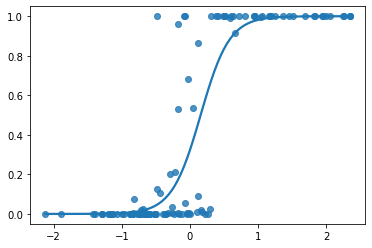

In [26]:
sns.regplot(x_test[:, 0], y_hat, logistic=True, ci=None)